## Tensorflow Probability - Hierarchical Meta-Analysis  
### Day 15-16/100 Days of TensorFlow Probability  

We're pretty much in full swing now. I've got MCMC working, using the NUTS sampler and the code is reasonably concise and intuitive. We've reached the point where we can start to tackle some really interesting analyses. Today I want to cover two things: I want to start to look at MCMC chain diagnostics and also begin to look at hierarchical modelling. 

For the cahin diagnostics, I will draw from [Adam Haber's great blog post](https://adamhaber.github.io/2019/10/21/Bayesian-golf-puttings,-NUTS,-and-optimizing-your-sampling-function-with-TensorFlow-Probability.html). And we will kick off our hierarchical journey with the eight schools problem from BDA3 (see the [RStan impelentation here](https://github.com/stan-dev/rstan/wiki/RStan-Getting-Started)).


### Setup  

We'll continue to use the NoUTurn Sampler from here on in. We need to make sure we have TFP version 0.8.0, then we'll create our helper functions for the sampler and for running the chains.

I am also going to install the arviz package, which we will use for the chain diagnostics (more on this later).

In [0]:
! pip3 install -q --upgrade tensorflow-probability==0.8.0
! pip3 install -q arviz

In [13]:
import tensorflow_probability as tfp

tfp.__version__

'0.8.0'

We'll define our basic reset_sess() function...

In [0]:
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

try:
  tf.compat.v1.enable_eager_execution()
except ValueError:
  pass

import matplotlib.pyplot as plt

from __future__ import print_function

def reset_sess(config=None):
    """
    Convenience function to create the TF graph & session or reset them.
    """

    global sess
    tf.reset_default_graph()
    try:
        sess.close()
    except:
        pass
    sess = tf.InteractiveSession(config=config)

### MCMC Chain diagnostics  

We'll be using the `ArviZ` package to interrogate the state of our MCMC chains. This was originally developed for PyMC3, and also has support for PyStan. The team are currently working on extending this to PyMC4, Tensorflow Probability and Edward.

You can [read the documentation here](https://arviz-devs.github.io/arviz/). [Adam Haber also has a great section describing it](https://adamhaber.github.io/2019/10/21/Bayesian-golf-puttings,-NUTS,-and-optimizing-your-sampling-function-with-TensorFlow-Probability.html). I am going to blatantly "borrow" Haber's `tfp_trace_to_arviz()` function (thank you!)

**UPDATE:** ArviZ now has a `from_tfp` method, which takes the posterior estimates and plots the chain. So, I don't need the method below any more.



In [0]:
# using pymc3 naming conventions, with log_likelihood instead of lp so that ArviZ can compute loo and waic
sample_stats_name = ['log_likelihood','tree_size','diverging','energy','mean_tree_accept']

def tfp_trace_to_arviz(
    tfp_trace,
    var_names=None, 
    sample_stats_name=sample_stats_name):
    
    samps, trace = tfp_trace
    if var_names is None:
        var_names = ["var " + str(x) for x in range(len(samps))]
        
    sample_stats = {k:v.numpy().T for k, v in zip(sample_stats_name, trace)}
    posterior = {name : tf.transpose(samp, [1, 0, 2]).numpy() for name, samp in zip(var_names, samps)}
    return az.from_dict(posterior=posterior, sample_stats=sample_stats)

There are a number of sampling statistics that we need to collect as our MCMC chains sample. Again, I am going to take this directly from Adam Haber's post. There is a [great little notebook](https://docs.pymc.io/notebooks/sampler-stats.html) about sampling statistics from PyMC3 which is well worth a read!

Let's define our `trace_fn` method, note that the objects below are the same as the `sample_stats_name` above.

In [0]:
def trace_fn(_, pkr):  
    return (
        pkr.inner_results.inner_results.target_log_prob,
        pkr.inner_results.inner_results.leapfrogs_taken,
        pkr.inner_results.inner_results.has_divergence,
        pkr.inner_results.inner_results.energy,
        pkr.inner_results.inner_results.log_accept_ratio
    )

The `trace_fn` will be passed into our `sample_chain` method. Other than that, there isn't really any changes that we need to make to the code, which is heopfully now becoming familiar. We will:  

  1. define the NUTS method  
  2. define the sample_chain method  

However, I was inspired by Haber's `run_nots_template()` method, which seems to be a nice little wrapper function. I want something similar to Stan's `sampling()` function...

In [0]:
def sampler(
    model = None,    # log-probability function
    nparams = None,  # number of parameters
    inits = None,    # initialisation for parameters
    trace_fn = None, # trace function
    iters = 2000,    # number of MCMC iterations
    warmup = 1000,   # warmup iterations
    chains = 1,
    bijectors_list = None):
  
  if not isinstance(inits, list):
    inits = [0.01] * nparams

  # I don't understand this part yet...
  # Dig into this in the future
  if bijectors_list is None:
    bijectors_list = [tfb.Identity()] * nparams

  kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
        tfp.mcmc.TransformedTransitionKernel(
            inner_kernel=tfp.mcmc.NoUTurnSampler(
                target_log_prob_fn = model,
                step_size=1.0
            ),
            bijector=[tfb.Identity()] * nparams
        ),
        target_accept_prob=.8,
        num_adaptation_steps=np.floor(0.5*warmup),
        step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
              inner_results=pkr.inner_results._replace(step_size=new_step_size)
          ),
        step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
        log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio,
    )

  samples, trace = tfp.mcmc.sample_chain(
      num_results = iters,
      num_burnin_steps = warmup,
      current_state = inits,
      kernel = kernel,
      trace_fn = trace_fn
  )

  return [samples, trace]

# compile the sampler
run_sampler = tf.function(sampler, autograph = False, experimental_compile = True)

You'll notice above that I have "pre-compiled" the `sampler()` function by passing it to `tf.function()`. Haber describes this in his post but in brief: this converts our function into a `tf.Graph` and *massivley* speeds up the execution of the method. 

I need to dig into this a bit more in the future. Haber points to the following resources:  

  - [Better performance with tf.function and AutoGraph](https://www.tensorflow.org/guide/function)  
  - [tf.function](https://www.tensorflow.org/api_docs/python/tf/function)  
  - [XLA: Optimizing Compiler for Machine Learning](https://www.tensorflow.org/xla)  
  

Quickly, before we move onto the eight schools model, let's convince ourselves that our sampler is working. I will estimate the rate of a known poisson process:

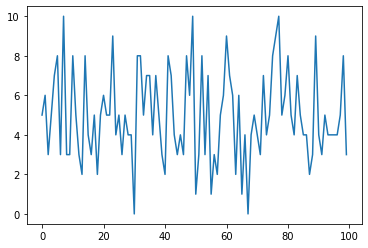

In [6]:
rv_poisson = tfd.Poisson(rate = 5)
data = rv_poisson.sample(100)

plt.plot(range(100), data.numpy())
plt.show()

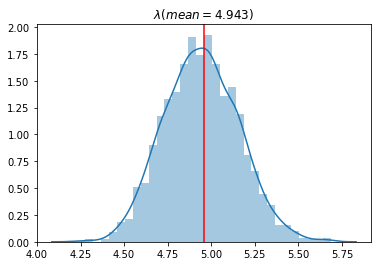

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lambda,4.943,0.212,4.552,5.332,0.007,0.005,885.0,884.0,892.0,1406.0,NaN


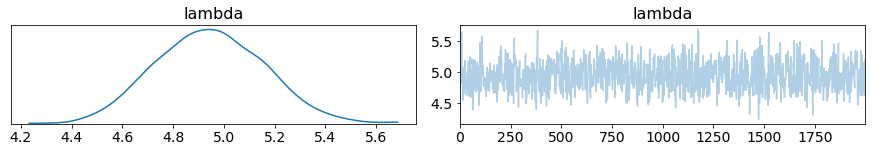

In [8]:
reset_sess()

def joint_log_prob(counts, estimated_rate):
  """
  Model our known poisson process
  """
  
  prior_rate = tfd.HalfCauchy(0., 1.)
  rv_count = tfd.Poisson(rate = estimated_rate)
  
  log_lik = (
      prior_rate.log_prob(estimated_rate) +
      tf.reduce_sum(rv_count.log_prob(counts))
  )
  
  return log_lik

def unnormalised_posterior(estimated_rate):
  return joint_log_prob(data, estimated_rate)
  
[rate_, trace] = run_sampler(
    model = unnormalised_posterior,
    nparams = 1,
    trace_fn = trace_fn
)

sns.distplot(rate_, label = "posterior")
plt.axvline(x = data.numpy().mean(), color = 'red')
plt.title("$\\lambda (mean = {:.3f})$".format(np.mean(rate_)))
plt.show()

trace1 = az.from_tfp(rate_, var_names = ["lambda"])
az.plot_trace(trace1)

az.summary(trace1)

Our sampler looks good - we've landed on the mean of our Poisson process. And I am really happy with the trace of the MCMC chain. Couple of things to address over the next week:  

  - how do I run multiple chains?  
  - why is RHat NaN?  

For now though, let's move onto the eight schools example.  

## Hierarchical modelling and the eight schools problem  

Hierarchical / multi-level models are one of my favourite modelling techniques. Hierarchical components provide a way to capture repeat structure in your data - and this is *everywhere* in most datasets. For example:

  1. sales businesses have repeat business to customers  
  2. marketing datasets usually involve distinct groups of customers which share behaviours  
  3. predictive maintenance tasks usually involve continual observations of machinery. For example, we monitor the time that it takes for database backups to complete; this can vary wildly from server to server, but they all share common traits (such as backup size, day of week etc).  

Repeat observations are literally everywhere in real-world data. But this is often ignored in popular machine learning approaches, which can lead to over-inflatted accuracy scores, overfitting and incomplete models. Gleman discusses this at length in Chapter 15 of Bayesian Data Analysis. And McElreath goes as far as [stating](http://elevanth.org/blog/2017/08/24/multilevel-regression-as-default/): "don't ask why you should a multilevel model. Ask instead, Why not?"


### The eight schools problem  

The eight schools problem is a really nice application of hierarchical modelling to combine the results of multiple studies. Gelman uses this dataset in BDA3 to demonstrate how to combine results to strengthen the quality of the conclusions, whilst accounting for possible differences in the individual studies.

Gelman spends quite a bit of time defining the scenario and setting up the problem, which is important as it helps to determine the model and aids with his interpretation of the results. I will paraphrase the problem below:  

```
SAT tests have been carefully designed to be resistant to short-term cramming 
or short-term training programmes. Instead, they are designed to test knowledge 
acquired over many years of education.

However, there are a large number of "schools" which offer short, intense 
training programmes which they claim boost their student's SAT scores. 

Importantly, there is no reason to believe these claims and Gelman compares the 
reported results over eight different schools to assess the validity of their 
claims. Are those schools which claim to have a large success rate really so
successful?


Chapter 5, p. 119, Gelman, Bayesian Data Analysis 3.
```


Here's the data that we will analyse:

In [17]:
schools = pd.DataFrame({
    'School': ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'],
    'y': [28, 8, -3, 7, -1, 1, 18, 12],   # the estimated treatment effect
    'sigma': [15, 10, 16, 11, 9, 11, 10, 18] #standard error of treatment effect
})
schools

,School,y,sigma
0,A,28,15
1,B,8,10
2,C,-3,16
3,D,7,11
4,E,-1,9
5,F,1,11
6,G,18,10
7,H,12,18


Marketing materials for a school are likely to focus on the mean treatment effect. Based on this alone, School A seems to be incredibly successful - and might, therefore, be worth any expense for such a large gain. 

But, we are lucky to have the standard errors here as well, which are all very large. In light of these, it seems very unlikely that any school can reliably promise to yield positive results. I would expect our hierarchical meta-analysis to confirm this.

### Hierarchical Models  

I am going to draw from the [Stan User Guide](https://mc-stan.org/docs/2_18/stan-users-guide/meta-analysis.html) and [Daniel Lee's Lecture Notes](https://astrostatistics.psu.edu/su14/lectures/Daniel-Lee-Stan-2.pdf) for this. We will develop two models, the first without hierarchical pooling and the second with pooling.

Let's begin with our first basic model, which will have the form:  

$y \sim Normal(\theta, \sigma) \\
\theta \sim Normal(0, 100)$

Here, we will assume that the schools are "all lumped together". That is, their results are drawn from some normal distribution and that they are all indepedent - knowing the results of any particular school doesn't necessarily inform our expectations of any other school.

We're getting used to the Tensorflow Probability code now, so we'll define the log-prob function and then sample.

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,7.697,4.072,0.343,15.248,0.131,0.093,966.0,966.0,962.0,1290.0,NaN


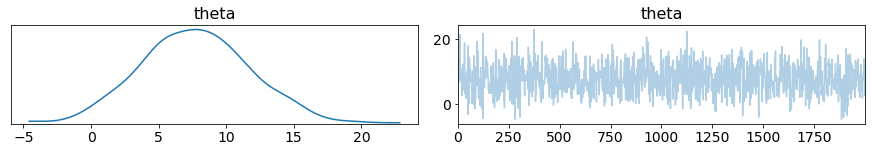

In [20]:
reset_sess()

def joint_log_prob(y, sigma, theta):
  """
  Eight schools Model One: no pooling

  Parameters:
  -----------
    @y: observed treatment effects
    @sigma: standard error of these treatment effects  
    @theta: the mean effect, which we will attempt to estimate
  """
  
  prior_theta = tfd.Normal(0, 100)
  rv_treatment = tfd.Normal(theta, sigma)
  
  log_lik = (
      prior_theta.log_prob(theta) +
      tf.reduce_sum(rv_treatment.log_prob(y))
  )
  
  return log_lik

def unnormalised_posterior(theta):
  return joint_log_prob(y, sigma, theta)
  
[y, sigma] = [
   np.array([x for x in schools.y], dtype=np.float32),
   np.array([x for x in schools.sigma], dtype=np.float32)
]
[theta_, trace] = run_sampler(
    model = unnormalised_posterior,
    nparams = 1,
    trace_fn = trace_fn
)


trace1 = az.from_tfp(theta_, var_names = ["theta"])
az.plot_trace(trace1)

az.summary(trace1)

As a starting point, this is certainly interesting. Our model suggests that there is an overall positive effect across these schools, with a mean effect of approx. 7.7 with a standard error of 4. Or, approximately [8 +/- 8]. This is exactly what Gelman reports in pg. 120 of BDA3. 


This is a great start. Unfortunately, I haven't figured out how to create the hierarchical model yet :( I really need to wrap my head around this - so will end this notebook here today and continue with this tomorrow.


For tomorrow, I will draw on this amazing walkthrough from the TFP team: https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Multilevel_Modeling_Primer.ipynb  and see how we go extending this to the eight schools data.